In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from trajectory_classifier.gmm import GaussianMixture
import matplotlib.pyplot as plt
import time
from scipy import spatial
from util.util import mnist_noise, correct_prob
from util.util import ImbalancedDatasetSampler

from trajectoryReweight.model import WeightedCrossEntropyLoss, TrajectoryReweightNN

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
"""
CNN & LeNet
"""
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def name(self):
        return "LeNet"

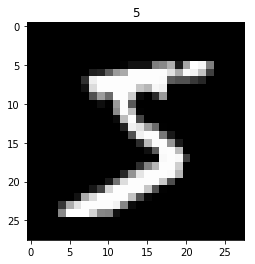

In [18]:
"""
MNIST DATA
"""
dataset = np.load('data/mnist.npz')
valid_idx = np.random.choice(range(60000), size=1000, replace=False)
x_valid = dataset['x_train'][valid_idx]
y_valid = dataset['y_train'][valid_idx]
x_train = np.delete(dataset['x_train'], valid_idx, axis=0)
y_train = np.delete(dataset['y_train'], valid_idx)
x_test = dataset['x_test']
y_test = dataset['y_test']

"""
shrink dataset to make noisy significant
"""
x_train = x_train[:10000]
y_train = y_train[:10000]

"""
Add Noise to training data
"""
y_train_noisy = mnist_noise(y_train,0.6)

"""
Plot an example
""" 
plt.imshow(x_train[0], cmap='gray')
plt.title('%i' % y_train[0])
plt.show()

In [19]:
"""
Initializaion
"""
train_idx = np.arange(len(x_train))
x_train = np.transpose(x_train,(2,1,0))
x_valid = np.transpose(x_valid,(2,1,0))
x_test = np.transpose(x_test,(2,1,0))
x_train_tensor = torchvision.transforms.ToTensor()(x_train).unsqueeze(1)
x_valid_tensor = torchvision.transforms.ToTensor()(x_valid).unsqueeze(1)
x_test_tensor = torchvision.transforms.ToTensor()(x_test).unsqueeze(1)
y_train_tensor = torch.from_numpy(y_train.astype(np.long))
y_train_noisy_tensor = torch.from_numpy(y_train_noisy.astype(np.long))
y_valid_tensor = torch.from_numpy(y_valid.astype(np.long))
y_test_tensor = torch.from_numpy(y_test.astype(np.long))

In [20]:
"""
CNN without reweight
"""
cnn = CNN()
cnn.to(device)

num_iter = 20
lr = 5e-5
batch_size = 100
L2 = 0.0005

optimizer = torch.optim.Adam(cnn.parameters(), lr=lr, weight_decay=L2)
loss_func = nn.CrossEntropyLoss()

tensor_noisy_dataset = Data.TensorDataset(x_train_tensor,y_train_noisy_tensor)
train_noisy_loader= Data.DataLoader(dataset=tensor_noisy_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_iter):
    for step, (b_x, b_y) in enumerate(train_noisy_loader):
        b_x, b_y = b_x.to(device), b_y.to(device)
        output = cnn(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        test_output = cnn(x_test_tensor.to(device))
        test_output_y = torch.max(test_output, 1)[1].data.cpu().numpy()
        test_accuracy = float((test_output_y == y_test_tensor.data.numpy()).astype(int).sum()) / float(y_test_tensor.size(0))
        print('epoch = {} | loss = {:.4f} | test accuracy = {:.4f}'.format(epoch+1, loss, test_accuracy))

epoch = 1 | loss = 2.1346 | test accuracy = 0.6436
epoch = 2 | loss = 2.0710 | test accuracy = 0.7986
epoch = 3 | loss = 1.9994 | test accuracy = 0.8491
epoch = 4 | loss = 2.0500 | test accuracy = 0.8710
epoch = 5 | loss = 2.1704 | test accuracy = 0.8805
epoch = 6 | loss = 1.9108 | test accuracy = 0.8896
epoch = 7 | loss = 1.9990 | test accuracy = 0.8914
epoch = 8 | loss = 2.1261 | test accuracy = 0.9049
epoch = 9 | loss = 1.9972 | test accuracy = 0.9205
epoch = 10 | loss = 1.9778 | test accuracy = 0.9154
epoch = 11 | loss = 2.0325 | test accuracy = 0.9254
epoch = 12 | loss = 2.0687 | test accuracy = 0.9256
epoch = 13 | loss = 1.9650 | test accuracy = 0.9221
epoch = 14 | loss = 2.0028 | test accuracy = 0.9208
epoch = 15 | loss = 1.9846 | test accuracy = 0.9215
epoch = 16 | loss = 1.9391 | test accuracy = 0.9259
epoch = 17 | loss = 2.0435 | test accuracy = 0.9236
epoch = 18 | loss = 1.9560 | test accuracy = 0.9225
epoch = 19 | loss = 2.0526 | test accuracy = 0.9265
epoch = 20 | loss = 1

In [16]:
"""
CNN with reweight
"""

cnn = CNN()
cnn.to(device)

tra_weightNN = TrajectoryReweightNN(cnn, 
                                    burnin=5, 
                                    num_cluster=10, 
                                    batch_size=100, 
                                    num_iter=15, 
                                    learning_rate=5e-5, 
                                    early_stopping=10)
tra_weightNN.fit(x_train_tensor, y_train_noisy_tensor, x_valid_tensor, y_valid_tensor,device)

Train 5 burn-in epoch...
Train 5 burn-in epoch complete.
------------------------------------------------------------
Trajectory clustering for burn-in epoch...
Trajectory clustering for burn-in epoch complete.
------------------------------------------------------------
Trajectory based training start ...

|-------------------------------------------------------------------
| - epoch = 2
| - compute valid set grad...
| - update cluster weight based on valid set...
| -  {0: 0, 'size': 1049, 'weight': 1.0855848789215088}
| -  {1: 1, 'size': 1089, 'weight': 1.0906578302383423}
| -  {2: 2, 'size': 854, 'weight': 1.0738710165023804}
| -  {3: 3, 'size': 1511, 'weight': 0.9213136434555054}
| -  {4: 4, 'size': 1092, 'weight': 0.9590571522712708}
| -  {5: 5, 'size': 579, 'weight': 1.0819971561431885}
| -  {6: 6, 'size': 757, 'weight': 1.0273687839508057}
| -  {7: 7, 'size': 1190, 'weight': 0.9128358364105225}
| -  {8: 8, 'size': 1219, 'weight': 1.0930501222610474}
| -  {9: 9, 'size': 660, 'wei

| -  {7: 7, 'size': 1384, 'weight': 0.2161998152732849}
| -  {8: 8, 'size': 1268, 'weight': 1.7933977842330933}
| -  {9: 9, 'size': 1471, 'weight': 0.25964587926864624}
| - mini-batch training based on cluster weights...
| - epoch = 10 | loss = 0.8367 | valid error = 0.0770
| - update trajectory cluster...
|-------------------------------------------------------------------

|-------------------------------------------------------------------
| - epoch = 11
| - compute valid set grad...
| - update cluster weight based on valid set...
| -  {0: 0, 'size': 984, 'weight': 1.9205034971237183}
| -  {1: 1, 'size': 1236, 'weight': 1.870374321937561}
| -  {2: 2, 'size': 832, 'weight': 0.11573831737041473}
| -  {3: 3, 'size': 1449, 'weight': 0.1374794989824295}
| -  {4: 4, 'size': 649, 'weight': 0.8934488296508789}
| -  {5: 5, 'size': 730, 'weight': 1.768159031867981}
| -  {6: 6, 'size': 856, 'weight': 0.21453356742858887}
| -  {7: 7, 'size': 1206, 'weight': 1.923339605331421}
| -  {8: 8, 'size'

In [21]:
test_output_y = tra_weightNN.predict(x_test_tensor,device)
test_accuracy = float((test_output_y == y_test_tensor.data.numpy()).astype(int).sum()) / float(y_test_tensor.size(0))
print('test accuracy is {}'.format(test_accuracy))

test accuracy is 0.9459


In [4]:
"""
Imbalanced MNIST DATA
"""
dataset = np.load('data/mnist.npz')

four_index = dataset['y_train'] == 4
nine_index = dataset['y_train'] == 9

y_fours = dataset['y_train'][four_index]-4
y_nines = dataset['y_train'][nine_index]-8
x_fours = dataset['x_train'][four_index]
x_nines = dataset['x_train'][nine_index]

valid_four_index = np.random.choice(range(len(y_fours)), size=250, replace=False)
valid_nine_index = np.random.choice(range(len(y_nines)), size=250, replace=False)

x_valid_four =  x_fours[valid_four_index]
x_valid_nine =  x_nines[valid_nine_index]
y_valid_four =  y_fours[valid_four_index]
y_valid_nine =  y_nines[valid_nine_index]

x_valid = np.append(x_valid_four,x_valid_nine,0)
y_valid = np.append(y_valid_four,y_valid_nine)
indices = np.arange(x_valid.shape[0])
np.random.shuffle(indices)
x_valid = x_valid[indices]
y_valid = y_valid[indices]

x_train_four = np.delete(x_fours, valid_four_index, axis=0)
y_train_four = np.delete(y_fours, valid_four_index)
x_train_nine = np.delete(x_nines, valid_four_index, axis=0)
y_train_nine = np.delete(y_nines, valid_four_index)

four_index = dataset['y_test'] == 4
nine_index = dataset['y_test'] == 9

y_fours = dataset['y_test'][four_index]-4
y_nines = dataset['y_test'][nine_index]-8
x_fours = dataset['x_test'][four_index]
x_nines = dataset['x_test'][nine_index]
x_test = np.append(x_fours,x_nines,0)
y_test = np.append(y_fours,y_nines)
indices = np.arange(x_test.shape[0])
np.random.shuffle(indices)
x_test = x_test[indices]
y_test = y_test[indices]

In [5]:
"""
Imbalanced MNIST Study
""" 
a = [500,250,125,62,31]

for ratio in [31]:
    print('ratio: 4:9 = {}:{}'.format(ratio, 5000-ratio))
    four_part = np.random.choice(range(len(x_train_four)), size=ratio, replace=False)
    nine_part = np.random.choice(range(len(x_train_nine)), size=5000-ratio, replace=False)
    x_train = np.append(x_train_four[four_part],x_train_nine[nine_part],0)
    y_train = np.append(y_train_four[four_part],y_train_nine[nine_part])
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]


    x_train = np.transpose(x_train,(2,1,0))
    x_valid = np.transpose(x_valid,(2,1,0))
    x_test = np.transpose(x_test,(2,1,0))
    x_train_tensor = torchvision.transforms.ToTensor()(x_train).unsqueeze(1)
    x_valid_tensor = torchvision.transforms.ToTensor()(x_valid).unsqueeze(1)
    x_test_tensor = torchvision.transforms.ToTensor()(x_test).unsqueeze(1)
    y_train_tensor = torch.from_numpy(y_train.astype(np.long))
    y_valid_tensor = torch.from_numpy(y_valid.astype(np.long))
    y_test_tensor = torch.from_numpy(y_test.astype(np.long))


#     """
#     baseline
#     """

#     lenet = LeNet().to(device=device)
#     num_iter = 80
#     lr = 0.001
#     batch_size = 100
#     L2 = 0.0005


#     tensor_dataset = Data.TensorDataset(x_train_tensor,y_train_tensor)
#     train_loader= Data.DataLoader(dataset=tensor_dataset, batch_size=batch_size, shuffle=True)
#     optimizer = torch.optim.Adam(lenet.parameters(), lr=lr, weight_decay=L2)
#     loss_func = nn.CrossEntropyLoss()
#     for epoch in range(num_iter):
#         for step, (b_x, b_y) in enumerate(train_loader):
#             b_x, b_y = b_x.to(device), b_y.to(device, torch.long)
#             output = lenet(b_x)
#             loss = loss_func(output, b_y)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#     with torch.no_grad():
#         test_output = lenet(x_test_tensor.to(device))
#         test_output_y = torch.max(test_output, 1)[1].data.cpu().numpy()
#         acc = 0
#         for pred, y in zip(test_output_y,y_test_tensor.data.numpy()):
#             if pred == y:
#                 acc += 1
#         test_accuracy = acc / float(y_test_tensor.size(0))
#         print('lenet baseline test error is ', 1-test_accuracy)

#     """
#     adjust class weight
#     """
#     lenet = LeNet().to(device=device)
#     optimizer = torch.optim.Adam(lenet.parameters(), lr=lr, weight_decay=L2)
#     weight = [float(5000/ratio), float(5000/(5000-ratio))]
#     weight = torch.FloatTensor(weight).to(device)
#     loss_func = nn.CrossEntropyLoss(weight=weight)
#     for epoch in range(num_iter):
#         for step, (b_x, b_y) in enumerate(train_loader):
#             b_x, b_y = b_x.to(device), b_y.to(device, torch.long)
#             output = lenet(b_x)
#             loss = loss_func(output, b_y)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#     with torch.no_grad():
#         test_output = lenet(x_test_tensor.to(device))
#         test_output_y = torch.max(test_output, 1)[1].data.cpu().numpy()
#         acc = 0
#         for pred, y in zip(test_output_y,y_test_tensor.data.numpy()):
#             if pred == y:
#                 acc += 1
#         test_accuracy = acc / float(y_test_tensor.size(0))
#         print('lenet with class weight test error is ', 1-test_accuracy)

#     """
#     resample to balance
#     """
#     lenet = LeNet().to(device=device)
#     optimizer = torch.optim.Adam(lenet.parameters(), lr=lr, weight_decay=L2)
#     tensor_dataset = Data.TensorDataset(x_train_tensor,y_train_tensor)
#     train_loader= Data.DataLoader(dataset=tensor_dataset, batch_size=batch_size, sampler=ImbalancedDatasetSampler(tensor_dataset), shuffle=False)
#     loss_func = nn.CrossEntropyLoss()
#     for epoch in range(num_iter):
#         for step, (b_x, b_y) in enumerate(train_loader):
#             b_x, b_y = b_x.to(device), b_y.to(device, torch.long)
#             output = lenet(b_x)
#             loss = loss_func(output, b_y)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#     with torch.no_grad():
#         test_output = lenet(x_test_tensor.to(device))
#         test_output_y = torch.max(test_output, 1)[1].data.cpu().numpy()
#         acc = 0
#         for pred, y in zip(test_output_y,y_test_tensor.data.numpy()):
#             if pred == y:
#                 acc += 1
#         test_accuracy = acc / float(y_test_tensor.size(0))
#         print('lenet with imbalance sampling test error is ', 1-test_accuracy)

ratio: 4:9 = 31:4969


In [6]:
lenet = LeNet()
lenet.to(device)

tra_weightNN = TrajectoryReweightNN(lenet, 
                                    burnin=10, 
                                    num_cluster=5, 
                                    batch_size=100, 
                                    num_iter=70, 
                                    learning_rate=1e-3,
                                    early_stopping=10)
tra_weightNN.fit(x_train_tensor, y_train_tensor, x_valid_tensor, y_valid_tensor,device)

Train 10 burn-in epoch...
Train 10 burn-in epoch complete.
------------------------------------------------------------
Trajectory clustering for burn-in epoch...
Trajectory clustering for burn-in epoch complete.
------------------------------------------------------------
Trajectory based training start ...

|-------------------------------------------------------------------
| - epoch = 2
| - compute valid set grad...
| - update cluster weight based on valid set...
| -  {4: 4, 'size': 5000, 'weight': 1.0663399696350098}
| - mini-batch training based on cluster weights...
| - epoch = 2 | loss = 0.0015 | valid error = 0.0560
| - update trajectory cluster...
|-------------------------------------------------------------------

|-------------------------------------------------------------------
| - epoch = 3
| - compute valid set grad...
| - update cluster weight based on valid set...
| -  {4: 4, 'size': 5000, 'weight': 0.97083580493927}
| - mini-batch training based on cluster weights.

In [8]:
test_output_y = tra_weightNN.predict(x_test_tensor,device)
test_accuracy = float((test_output_y == y_test_tensor.data.numpy()).astype(int).sum()) / float(y_test_tensor.size(0))
print('test accuracy is {}'.format(test_accuracy))

test accuracy is 0.9422400803616273
